<a href="https://colab.research.google.com/github/JJFelix/prediction-models/blob/master/cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

!pip install Boruta

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
from boruta import BorutaPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00


**1. Load Dataset**

In [ ]:
# Load each disease data
cancer1 = pd.read_csv("cancer1.csv")
cancer2 = pd.read_csv("cancer2.csv")

data = cancer1
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

**2. Data Preprocessing**

In [ ]:
data.drop(['PEER_PRESSURE'], axis=1, inplace=True)


# Label encoding categorical features (if any)
le = LabelEncoder()
data["GENDER"] = le.fit_transform(data["GENDER"])
data["LUNG_CANCER"] = le.fit_transform(data["LUNG_CANCER"])


# # data.describe()
# data.describe(include =[np.number])
# # data.describe(include =[object])
data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,2,2,2,1,1,1,2,2,2,1
2,0,59,1,1,1,1,2,1,2,1,2,2,1,2,0
3,1,63,2,2,2,1,1,1,1,2,1,1,2,2,0
4,0,63,1,2,1,1,1,1,2,1,2,2,1,1,0


**3. Handling missing values**

In [ ]:
# missing values
# data.fillna(data.mean(), inplace=True)
missing_data = data.isnull().sum()
total_percentage = (missing_data.sum() /data.shape[0]) * 100
print(f'Percentage of missing data: {round(total_percentage, 2)}%')

Percentage of missing data: 0.0%


In [ ]:
# missing data per category
total = data.isnull().sum().sort_values(ascending=False)
percent_total = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100
missing = pd.concat([total, percent_total], axis=1, keys=["Total", "Percentage"])
missing_data = missing[missing['Total']>0]
missing_data

,Total,Percentage


In [ ]:
# drop null entries (they are only 12%)
data.dropna(axis=0, inplace=True)
# data.to_csv('c_data.csv', index=False)
# X = data.iloc[:,:-1]
# y = data.iloc[:,-1].values.reshape(-1,1)

# # Save features (X) to a CSV file
# X.to_csv('features.csv', index=False)

# # Save labels (y) to a CSV file
# pd.DataFrame(y).to_csv('labels.csv', index=False)

# X.shape
# y.shape

In [ ]:
data.info()

# positive_count = cardio_data[cardio_data["TenYearCHD"] == 1].shape[0]
# negative_count = cardio_data[cardio_data["TenYearCHD"] == 0].shape[0]

# Print the counts
# print(f"Positive instances: {positive_count}")
# print(f"Negative instances: {negative_count}")

# dataset imbalanced

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   GENDER                 309 non-null    int64
 1   AGE                    309 non-null    int64
 2   SMOKING                309 non-null    int64
 3   YELLOW_FINGERS         309 non-null    int64
 4   ANXIETY                309 non-null    int64
 5   CHRONIC DISEASE        309 non-null    int64
 6   FATIGUE                309 non-null    int64
 7   ALLERGY                309 non-null    int64
 8   WHEEZING               309 non-null    int64
 9   ALCOHOL CONSUMING      309 non-null    int64
 10  COUGHING               309 non-null    int64
 11  SHORTNESS OF BREATH    309 non-null    int64
 12  SWALLOWING DIFFICULTY  309 non-null    int64
 13  CHEST PAIN             309 non-null    int64
 14  LUNG_CANCER            309 non-null    int64
dtypes: int64(15)
memory usage: 36.3 KB


**4. Viewing the data distribution**

<ipython-input-37-28956f241dd2>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax = ax)


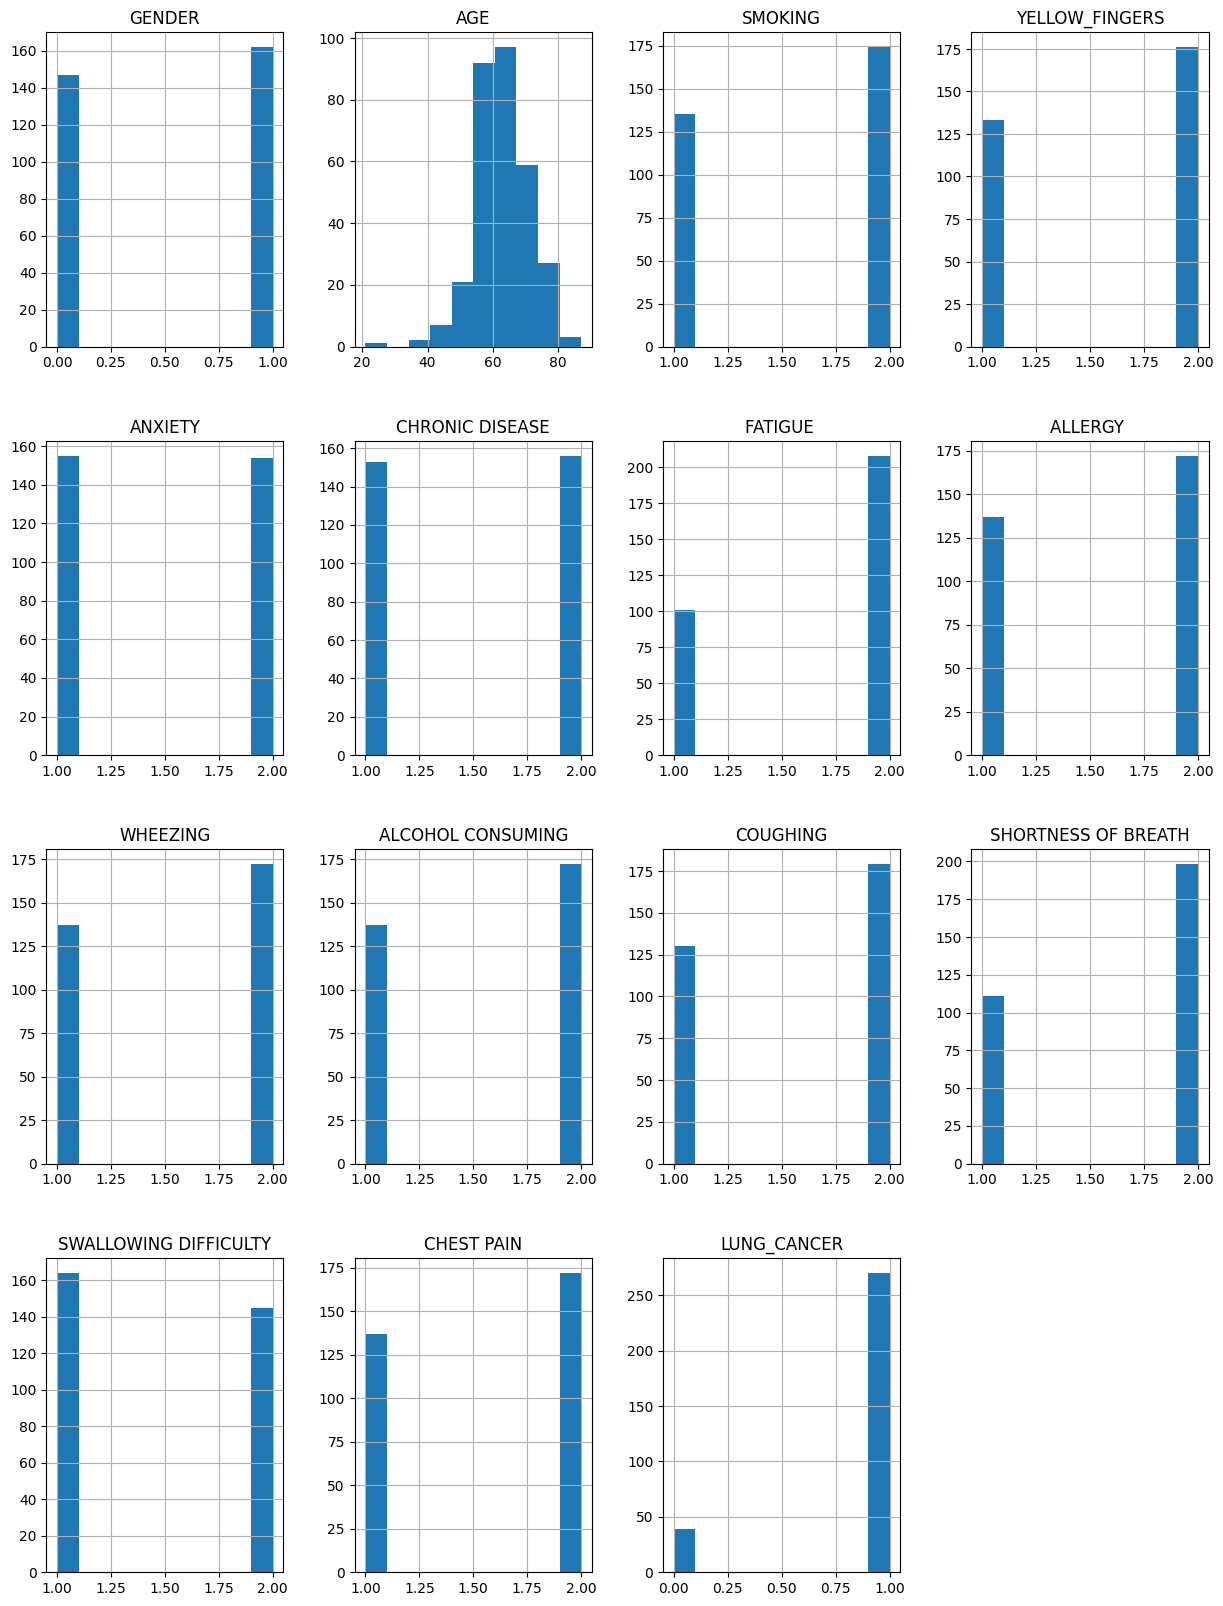

In [ ]:
# plot histogram to see the distribution of the data
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax)
plt.show()

**4.1. Case Counts**

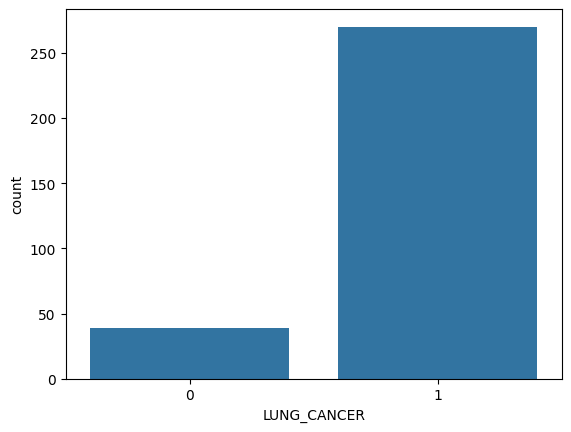

There are 39 patients without lung cancer disease and 270 patients with the disease


In [ ]:
sns.countplot(x='LUNG_CANCER',data=data)
plt.show()
cases = data.LUNG_CANCER.value_counts()
print(f"There are {cases[0]} patients without lung cancer disease and {cases[1]} patients with the disease")

**4.2. Disease vs Age**

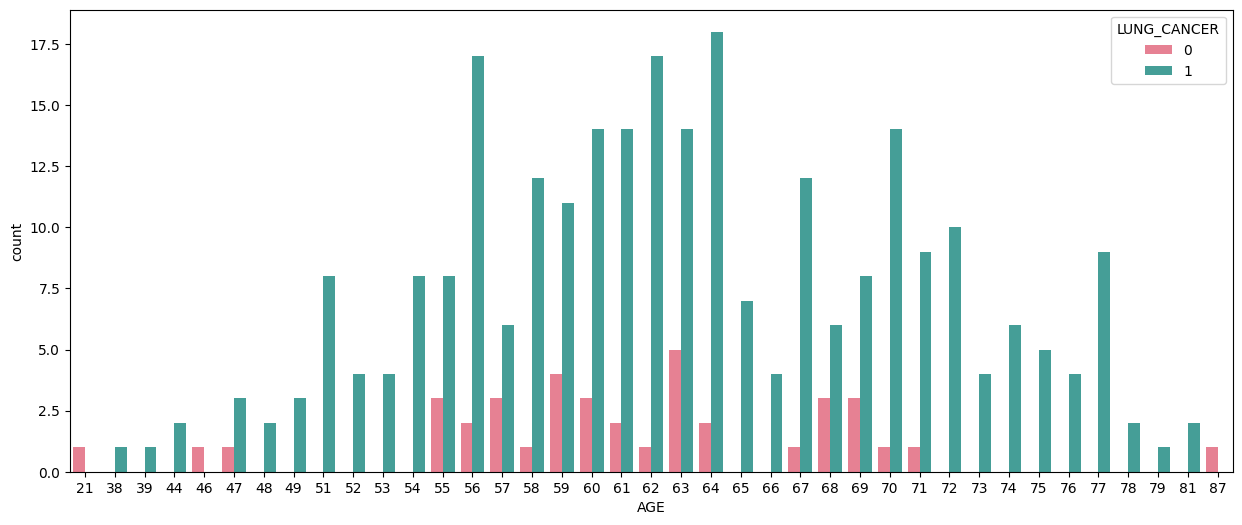

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(x='AGE',data = data, hue = 'LUNG_CANCER',palette='husl')
plt.show()

The people with the highest risk of developing CHD are betwwen the ages of 51 and 63

**4.3. Correlation Heatmap**

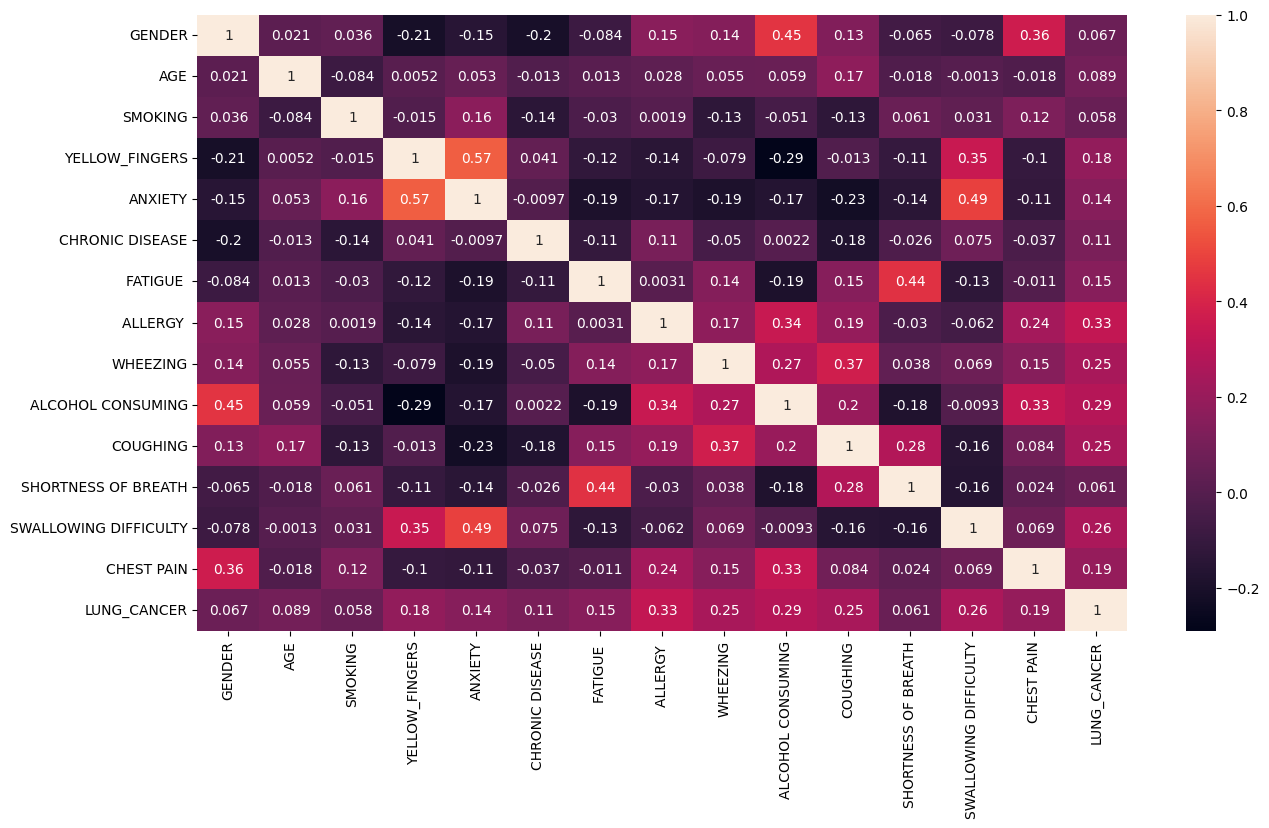

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot = True)
plt.show()

**5. Feature Selection**

In [ ]:
# define the features
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
feat_selector.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	10
Itera

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=20, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x799EBC0A9D40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x799EBC0A9D40, verbose=2)

In [ ]:
# most important features
most_important = data.columns[:-1][feat_selector.support_].tolist()
most_important

['ALLERGY ']

In [ ]:
# select the top 9 features
top_features = data.columns[:-1][feat_selector.ranking_ <=10].tolist()
top_features

['AGE',
 'YELLOW_FINGERS',
 'ANXIETY',
 'CHRONIC DISEASE',
 'FATIGUE ',
 'ALLERGY ',
 'WHEEZING',
 'ALCOHOL CONSUMING',
 'COUGHING',
 'SWALLOWING DIFFICULTY']

In [ ]:
import statsmodels.api as sm

X_top = data[top_features]
y = data['LUNG_CANCER']

res = sm.Logit(y,X_top).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.269996
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            LUNG_CANCER   No. Observations:                  309
Model:                          Logit   Df Residuals:                      299
Method:                           MLE   Df Model:                            9
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.2878
Time:                        08:33:18   Log-Likelihood:                -83.429
converged:                       True   LL-Null:                       -117.15
Covariance Type:            nonrobust   LLR p-value:                 4.822e-11
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
AGE                      -0.1110      0.025     -4.477      0.000      -0.160      -0.062
YELLOW_FINGERS            0.4635      0.513      0.904      0.366      -0.541       1.468
ANXIETY                   0.0541      0.533      0.102      0.919      -0.991       1.099
CHRONIC DISEASE           0.4562      0.443      1.031      0.303      -0.411       1.324
FATIGUE                   0.7109      0.436      1.632      0.103      -0.143       1.565
ALLERGY                   1.3481      0.489      2.759      0.006       0.390       2.306
WHEEZING                  0.2486      0.495      0.502      0.616      -0.722       1.220
ALCOHOL CONSUMING         0.9174      0.502      1.828      0.068      -0.066       1.901
COUGHING                  0.8542      0.514      1.662      0.097      -0.153       1.862
SWALLOWING DIFFICULTY     1.2234      0.527      2.321      0.020       0.190       2.256
=========================================================================================
"""

In [ ]:
params = res.params
conf = res.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                             5%        95%  Odds Ratio
AGE                    0.852437   0.939474    0.894898
YELLOW_FINGERS         0.582060   4.341423    1.589644
ANXIETY                0.371167   3.002315    1.055633
CHRONIC DISEASE        0.662707   3.757615    1.578036
FATIGUE                0.866874   4.781533    2.035924
ALLERGY                1.477589  10.032767    3.850234
WHEEZING               0.485576   3.385780    1.282206
ALCOHOL CONSUMING      0.935690   6.693901    2.502682
COUGHING               0.857953   6.433610    2.349412
SWALLOWING DIFFICULTY  1.209557   9.549391    3.398608


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-pack

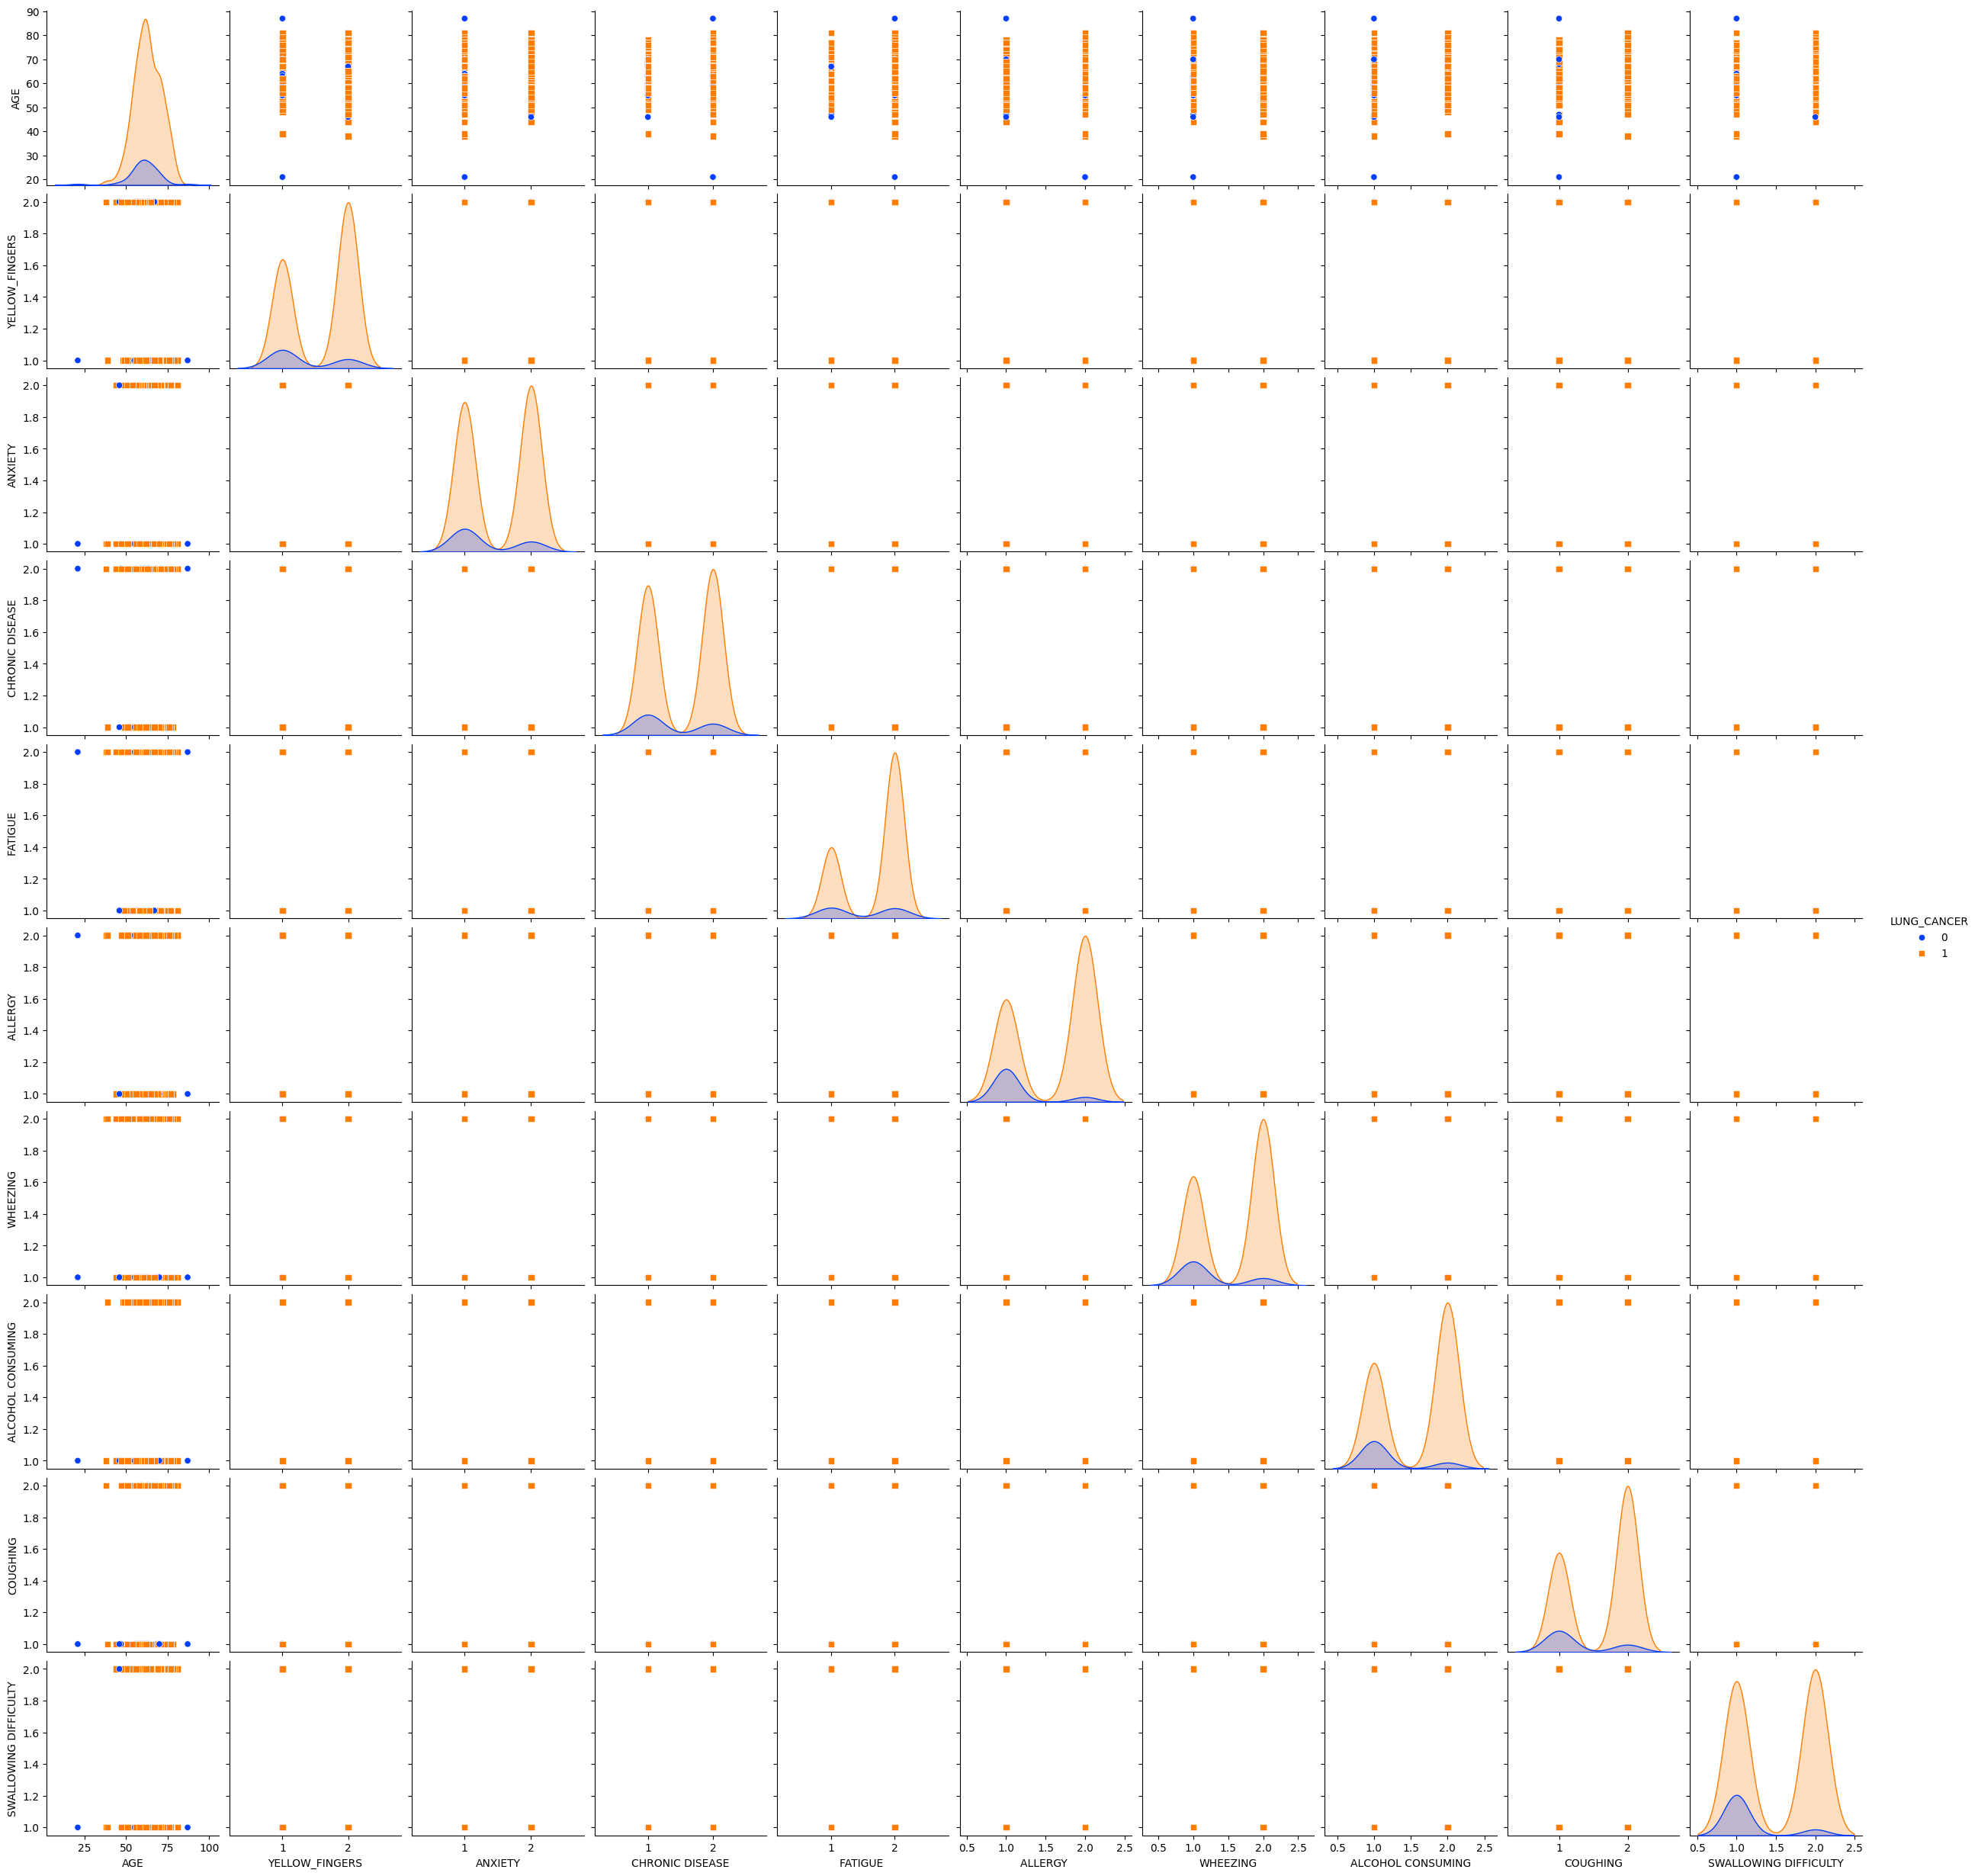

In [ ]:
sns.pairplot(data, hue = 'LUNG_CANCER', markers=["o", "s"], vars = top_features, palette = sns.color_palette("bright", 10))

**6. Balancing dataset - SMOTE**

In [ ]:
# rectifying class imbalance
# 1. Oversampling
# from imblearn.over_sampling import RandomOverSampler
# X = data.drop("TenYearCHD", axis=1) # features
# y = data["TenYearCHD"] # target

# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
# 2. Undersamping - not ideal (throws away data)
# from sklearn.utils import resample
# X = cardio_data.drop("TenYearCHD", axis=1).iloc[:, :] # features
# y = cardio_data["TenYearCHD"] # target

# X_resampled, y_resampled = resample(X[y == 0],
#                                       replace=False,
#                                       n_samples=len(y[y == 1]),
#                                       random_state=42)

# X_resampled2 = pd.concat([X_resampled, X[y == 1]], ignore_index=True)
# y_resampled2 = pd.concat([y[y_resampled], y[y == 1]], ignore_index=True)


In [ ]:
X = data[top_features]
y  = data.iloc[:,-1]

In [ ]:
# the numbers before smote
num_before = dict(Counter(y))

# smoting
# define pipeline
over = SMOTE(sampling_strategy=0.8)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_smote, y_smote = pipeline.fit_resample(X, y)

#the numbers after smote
num_after =dict(Counter(y_smote))

print(num_before, num_after)

{1: 270, 0: 39} {0: 216, 1: 270}


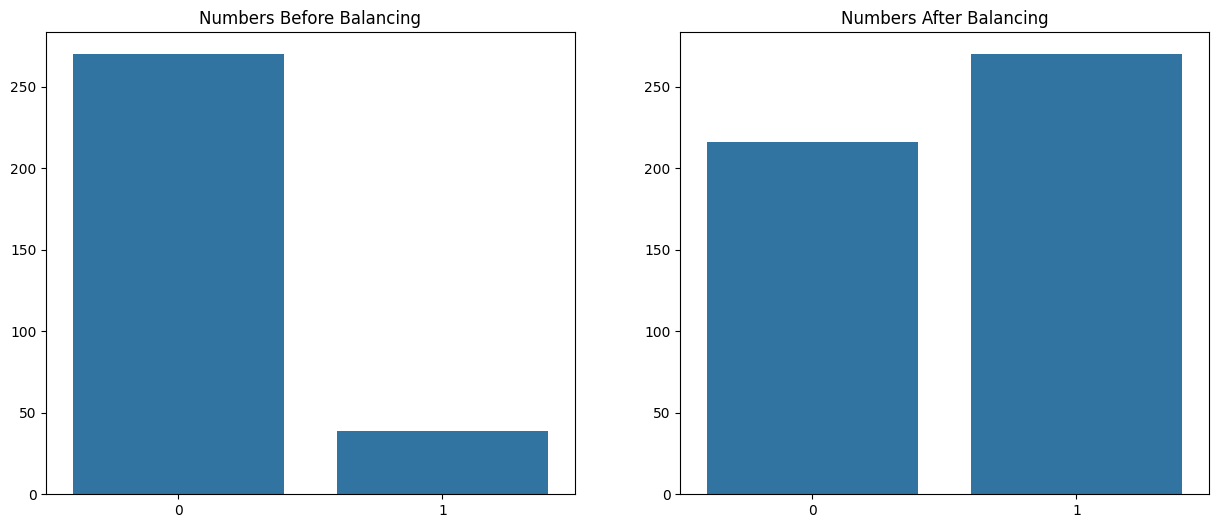

In [ ]:
labels = ["Negative Cases","Positive Cases"]
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(list(num_before.values()))
plt.title("Numbers Before Balancing")
plt.subplot(1,2,2)
sns.barplot(list(num_after.values()))
plt.title("Numbers After Balancing")
plt.show()

In [ ]:
# 3. SMOTE - Synthetic Minority Over-sampling Technique
# '''
# Creates synthetic data pounts for the minority class based on existing data
# '''
# from imblearn.over_sampling import SMOTE
# X = cardio_data.drop("TenYearCHD", axis=1) # features
# y = cardio_data["TenYearCHD"] # target

# smote = SMOTE(random_state=42)
# X_resampled3, y_resampled3 = smote.fit_resample(X, y)
print(top_features)


['AGE', 'YELLOW_FINGERS', 'ANXIETY', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING', 'ALCOHOL CONSUMING', 'COUGHING', 'SWALLOWING DIFFICULTY']


**7. Training and Testing Set**

In [ ]:
# new dataset
new_data = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis=1)
new_data.columns =  ['AGE', 'YELLOW_FINGERS', 'ANXIETY', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING', 'ALCOHOL CONSUMING', 'COUGHING', 'SWALLOWING DIFFICULTY', 'LUNG_CANCER']
new_data.head()

,AGE,YELLOW_FINGERS,ANXIETY,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SWALLOWING DIFFICULTY,LUNG_CANCER
0,59,1,1,1,2,1,2,1,2,1,0
1,63,2,2,1,1,1,1,2,1,2,0
2,63,2,1,1,1,1,2,1,2,1,0
3,68,1,2,1,2,1,1,1,1,1,0
4,60,1,1,1,2,1,1,1,1,1,0


In [ ]:
X_new = new_data[top_features]
y_new = new_data.iloc[:,-1]
X_new.head()
# y_new.head()

,AGE,YELLOW_FINGERS,ANXIETY,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SWALLOWING DIFFICULTY
0,59,1,1,1,2,1,2,1,2,1
1,63,2,2,1,1,1,1,2,1,2
2,63,2,1,1,1,1,2,1,2,1
3,68,1,2,1,2,1,1,1,1,1
4,60,1,1,1,2,1,1,1,1,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=.2, random_state=42)

**8. Feature Scaling**

In [ ]:
scaler  = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

X_test.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.060468,-0.851143,-0.734631,1.259630,0.925451,1.400654,-0.74715,-0.713952,-0.772469,-0.669150
1,-0.611207,-0.851143,-0.734631,1.259630,0.925451,1.400654,-0.74715,1.400654,1.294551,-0.669150
2,-1.161947,1.174891,1.361228,-0.793884,0.925451,1.400654,-0.74715,-0.713952,-0.772469,1.494434
3,-0.060468,1.174891,1.361228,-0.793884,0.925451,1.400654,-0.74715,1.400654,-0.772469,1.494434
4,-1.382242,-0.851143,-0.734631,1.259630,0.925451,1.400654,1.33842,1.400654,1.294551,1.494434


**9. Models**

**9.1 Bagged Decision Trees**

In [ ]:
bagged_dt = BaggingClassifier(estimator=DecisionTreeClassifier())

# grid search for optimum parameters
params = {
    'n_estimators': [10, 50, 100, 200],
    'base_estimator__max_depth': [None] + list(np.arange(10, 31, 5)),
    'base_estimator__min_samples_split': list(np.arange(2, 16)),
    'base_estimator__min_samples_leaf': list(np.arange(1, 12)),
    'max_features': [0.5, 0.75, 1.0],  # Fraction of features to consider for each base estimator
    'bootstrap': [True, False],  # Whether samples are drawn with replacement
    'bootstrap_features': [True, False]  # Whether features are drawn with replacement
}

n_iter_search = 100
bagged_dt_clf = RandomizedSearchCV(estimator=bagged_dt, param_distributions=params, n_iter=n_iter_search, cv=5, n_jobs=-1)

In [ ]:
# training
bagged_dt_clf.fit(X_train, y_train)
bagged_dt_clf.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


{'n_estimators': 50,
 'max_features': 0.5,
 'bootstrap_features': True,
 'bootstrap': False,
 'base_estimator__min_samples_split': 8,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__max_depth': 20}

In [ ]:
# predictions
bagged_dt_predict = bagged_dt_clf.predict(X_test)

# accuracy and f1
bagged_dt_accuracy = accuracy_score(y_test, bagged_dt_predict)
bagged_dt_f1 = f1_score(y_test, bagged_dt_predict)

print(f"Bagged Decision Trees accuracy: {round(bagged_dt_accuracy*100,2)}%")
print(f'The f1 score for BDT is {round(bagged_dt_f1*100,2)}%')

Bagged Decision Trees accuracy: 92.86%
The f1 score for BDT is 93.91%


<Axes: >

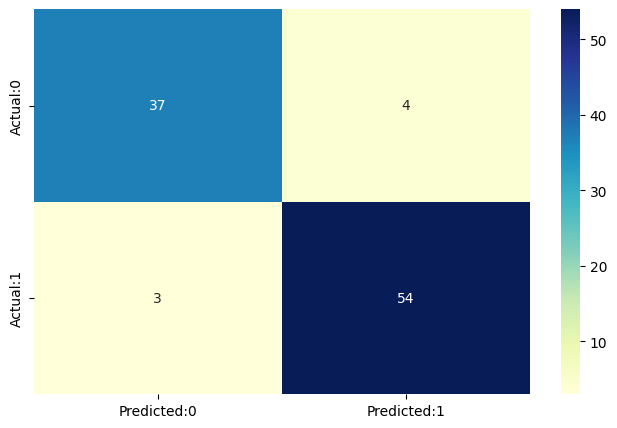

In [ ]:
# confusion matrix
cm=confusion_matrix(y_test, bagged_dt_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [ ]:
# classification report
print(classification_report(y_test,bagged_dt_predict))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        41
           1       0.93      0.95      0.94        57

    accuracy                           0.93        98
   macro avg       0.93      0.92      0.93        98
weighted avg       0.93      0.93      0.93        98



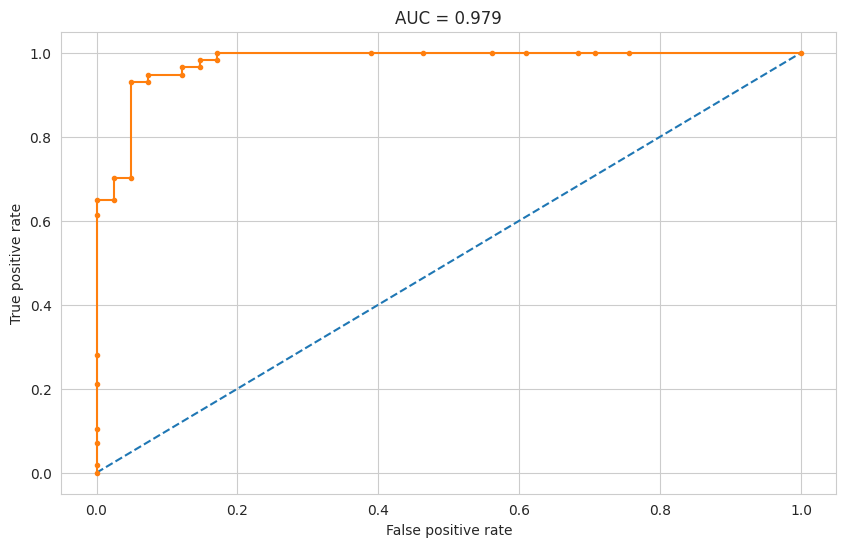

In [ ]:
# ROC and AUC
# ROC curve and AUC
probs = bagged_dt_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
bagged_dt_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(bagged_dt_auc,3)}")
plt.show()

**9.2 Random Forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=100)

# grid search for optimum parameters
params = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}
n_iter_search = 100
rf_clf = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=n_iter_search, cv=5, n_jobs=-1)

In [ ]:
rf_clf.fit(X_train, y_train)
rf_clf.best_params_

{'n_estimators': 10,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30}

In [ ]:
# predictions
rf_predict = rf_clf.predict(X_test)

# accuracy and f1
rf_accuracy = accuracy_score(y_test, rf_predict)
rf_f1 = f1_score(y_test, rf_predict)

print(f"RandomForest accuracy: {round(rf_accuracy*100,2)}%")
print(f'The f1 score for RF is {round(rf_f1*100,2)}%')

RandomForest accuracy: 93.88%
The f1 score for RF is 94.74%


<Axes: >

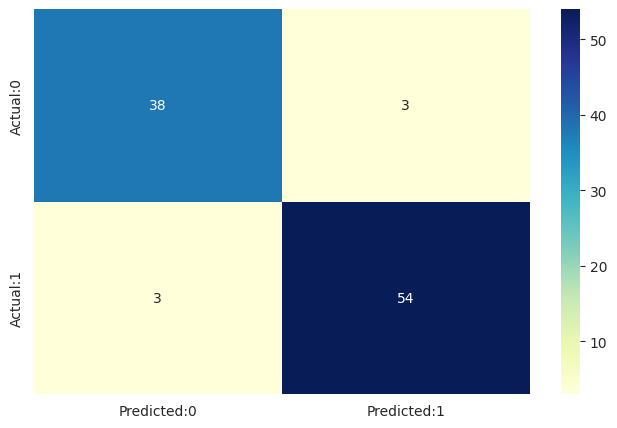

In [ ]:
# confusion matrix
cm=confusion_matrix(y_test, rf_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [ ]:
# classification report
print(classification_report(y_test,rf_predict))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        41
           1       0.95      0.95      0.95        57

    accuracy                           0.94        98
   macro avg       0.94      0.94      0.94        98
weighted avg       0.94      0.94      0.94        98



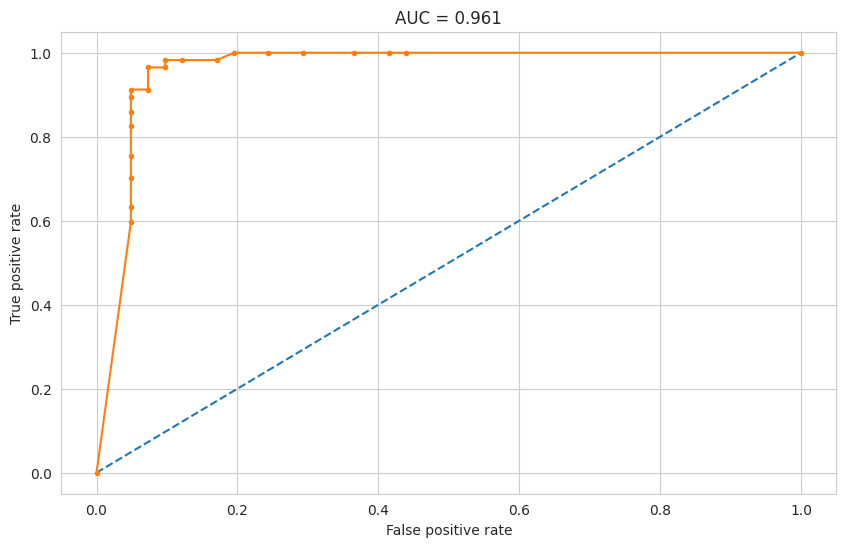

In [ ]:
# ROC and AUC
# ROC curve and AUC
probs = rf_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
rf_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(rf_auc,3)}")
plt.show()

**9.3 Stochastic Gradient Boosting**

In [ ]:
gb = GradientBoostingClassifier()

# Define the parameter grid
params = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': list(np.arange(2, 16)),
    'min_samples_leaf': list(np.arange(1, 12)),
    'max_features': [0.5, 0.75, 1.0],
    'subsample': [0.5, 0.75, 1.0]
}

n_iter_search = 100

gb_clf = RandomizedSearchCV(estimator=gb, param_distributions=params, n_iter=n_iter_search, cv=5, n_jobs=-1)

In [ ]:
# Train the model
gb_clf.fit(X_train, y_train)
gb_clf.best_params_

{'subsample': 1.0,
 'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 11,
 'max_features': 0.5,
 'max_depth': 6,
 'learning_rate': 0.1}

In [ ]:
# predictions
gb_predict = gb_clf.predict(X_test)

# accuracy and f1
gb_accuracy = accuracy_score(y_test, gb_predict)
gb_f1 = f1_score(y_test, gb_predict)

print(f"SGB accuracy: {round(gb_accuracy*100,2)}%")
print(f'The f1 score for gb is {round(gb_f1*100,2)}%')

SGB accuracy: 94.9%
The f1 score for gb is 95.65%


<Axes: >

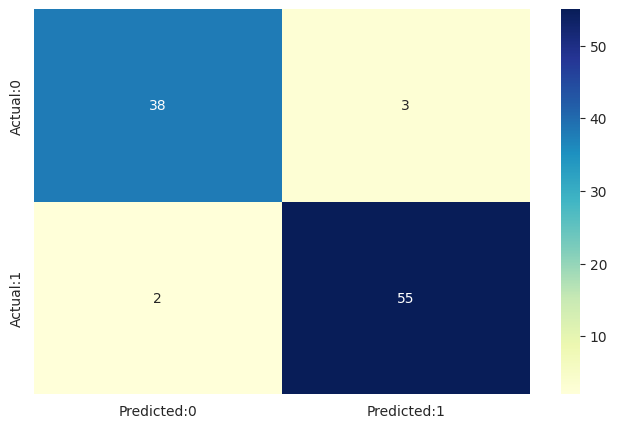

In [ ]:
# confusion matrix
cm=confusion_matrix(y_test, gb_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [ ]:
# classification report
print(classification_report(y_test,gb_predict))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        41
           1       0.95      0.96      0.96        57

    accuracy                           0.95        98
   macro avg       0.95      0.95      0.95        98
weighted avg       0.95      0.95      0.95        98



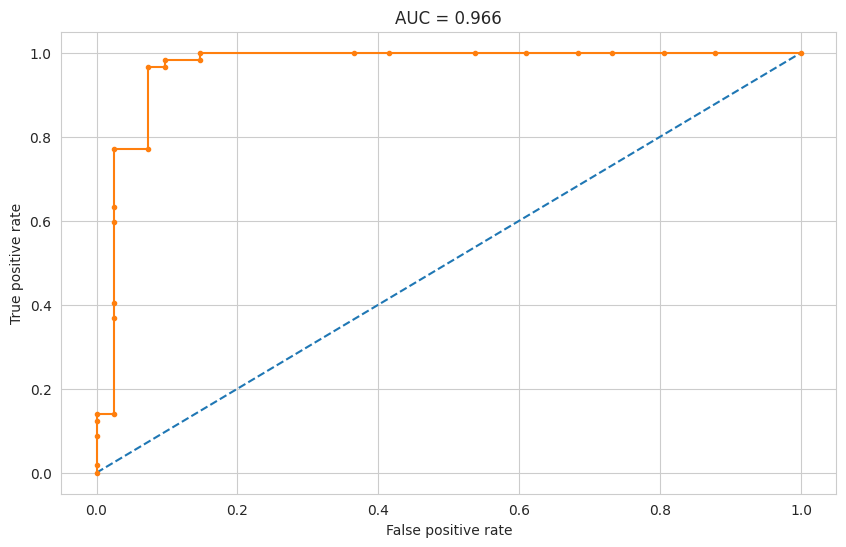

In [ ]:
# ROC and AUC
# ROC curve and AUC
probs = gb_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
gb_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(gb_auc,3)}")
plt.show()

**10. Building the ensemble**

In [ ]:
ensemble = VotingClassifier(
    estimators=[
        ('bagged_tree', bagged_dt_clf),
        ('random_forest', rf_clf),
        ('gradient_boosting', gb_clf)
    ], voting='soft')

ensemble.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


VotingClassifier(estimators=[('bagged_tree',
                              RandomizedSearchCV(cv=5,
                                                 estimator=BaggingClassifier(estimator=DecisionTreeClassifier()),
                                                 n_iter=100, n_jobs=-1,
                                                 param_distributions={'base_estimator__max_depth': [None,
                                                                                                    10,
                                                                                                    15,
                                                                                                    20,
                                                                                                    25,
                                                                                                    30],
                                                                      'base_estimator__min_samples_leaf': [1,
                                                                                                           2,
                                                                                                           3,
                                                                                                           4,
                                                                                                           5,
                                                                                                           6,
                                                                                                           7,
                                                                                                           8,
                                                                                                           9,
                                                                                                           10,
                                                                                                           11],
                                                                      'base_estimator__min_samples_split': [2,
                                                                                                            3,
                                                                                                            4,
                                                                                                            5,
                                                                                                            6,
                                                                                                            7,
                                                                                                            8,
                                                                                                            9,
                                                                                                            10,
                                                                                                            11,
                                                                                                            12,
                                                                                                            13,...
                              RandomizedSearchCV(cv=5,
                                                 estimator=GradientBoostingClassifier(),
                                                 n_iter=100, n_jobs=-1,
                                                 param_distributions={'learning_rate': [0.01,
                                                                                        0.05,
                                                                                        0.1,
                                      

In [ ]:
# predictions
ensemble_predict = ensemble.predict(X_test)

# accuracy and f1
ensemble_accuracy = accuracy_score(y_test, ensemble_predict)
ensemble_f1 = f1_score(y_test, ensemble_predict)

print(f"ensemble accuracy: {round(ensemble_accuracy*100,2)}%")
print(f'The f1 score for ensemble is {round(ensemble_f1*100,2)}%')

ensemble accuracy: 93.88%
The f1 score for ensemble is 94.83%


In [ ]:
# predict probabilities
proba_scores = ensemble.predict_proba(X_test)
print(proba_scores)

[[0.29155709 0.70844291]
 [0.04232857 0.95767143]
 [0.03453423 0.96546577]
 [0.02621453 0.97378547]
 [0.00493016 0.99506984]
 [0.10643451 0.89356549]
 [0.91454619 0.08545381]
 [0.01708674 0.98291326]
 [0.83776245 0.16223755]
 [0.12172879 0.87827121]
 [0.03693301 0.96306699]
 [0.96588848 0.03411152]
 [0.00103632 0.99896368]
 [0.58799846 0.41200154]
 [0.0339017  0.9660983 ]
 [0.27533285 0.72466715]
 [0.90650981 0.09349019]
 [0.75147332 0.24852668]
 [0.06039456 0.93960544]
 [0.98460476 0.01539524]
 [0.00479003 0.99520997]
 [0.30766234 0.69233766]
 [0.71568525 0.28431475]
 [0.06679189 0.93320811]
 [0.0793525  0.9206475 ]
 [0.94170872 0.05829128]
 [0.08365694 0.91634306]
 [0.00533479 0.99466521]
 [0.8720647  0.1279353 ]
 [0.95875442 0.04124558]
 [0.88743103 0.11256897]
 [0.17508376 0.82491624]
 [0.02594614 0.97405386]
 [0.75905952 0.24094048]
 [0.4420441  0.5579559 ]
 [0.76073605 0.23926395]
 [0.02723596 0.97276404]
 [0.03169183 0.96830817]
 [0.00401869 0.99598131]
 [0.88608824 0.11391176]


In [ ]:
# patient_data = [[48, 10, 1, 232, 138, 90, 22.37, 64, 72]]
# scaled_patient_data = scaler.transform(patient_data)
# scaled_patient_data_2d = np.array(scaled_patient_data).reshape(1,-1)
# scaled_patient_data_2d
# proba_scores = ensemble.predict_proba(scaled_patient_data_2d)

# print("Probability score for class 1(risk score): ", proba_scores[0][1])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 9 features, but StandardScaler is expecting 10 features as input.

**11. Saving the model**

In [ ]:
import pickle, joblib
file_path = 'cancer_ensemble_model.pkl'

with open(file_path, 'wb') as file:
  pickle.dump(ensemble, file)

# using joblib
joblib.dump(ensemble, "cancer_ensemble_model.joblib", compress=3)

print('Ensemble model saved successfully')

Ensemble model saved successfully
